In [1]:
from dataclasses import dataclass

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import optax
import qctrlvisualizer as qv
import qutip as qt
from jax import Array
from jax.scipy.linalg import expm
from jax.typing import ArrayLike


@dataclass
class OptimizationResult:
    times: npt.NDArray[np.float64]
    params: npt.NDArray[np.float64]
    pulse: npt.NDArray[np.complex128]
    history: npt.NDArray[np.float64]

    def plot_pulse(self):
        pulse = np.append(self.pulse, self.pulse[-1])
        pulse = pulse / (2 * np.pi) * 1e3
        plt.step(self.times, np.real(pulse), where="post", label="I")
        plt.step(self.times, np.imag(pulse), where="post", label="Q")
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.xlabel("Time (ns)")
        plt.ylabel("Amplitude (MHz)")
        plt.legend()
        plt.show()

    def plot_history(self):
        plt.plot(self.history)
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.yscale("log")
        plt.xlabel("Iteration")
        plt.ylabel("Objective Function")


@dataclass
class SimulationResult:
    times: npt.NDArray[np.float64]
    unitaries: npt.NDArray[np.complex128]
    states: npt.NDArray[np.complex128]

    @property
    def dimension(self) -> int:
        return self.states.shape[1]

    @property
    def populations(self) -> npt.NDArray[np.float64]:
        return np.abs(self.states.squeeze()) ** 2

    def display_bloch_sphere(self):
        states = self.states.squeeze()
        qv.display_bloch_sphere(states[:, :2])

    def plot_populations(self):
        qv.plot_population_dynamics(
            sample_times=self.times * 1e-9,
            populations={
                rf"$|{k}\rangle$": self.populations[:, k] for k in range(self.dimension)
            },
        )

    def print_final_populations(self):
        population = self.populations[-1]
        for k in range(self.dimension):
            print(f"|{k}> : {population[k]:>6.2%}")

In [2]:
class PulseOptimizer:
    def __init__(
        self,
        dimension: int,
        detuning: float,
        anharmonicity: float,
        segment_count: int,
        segment_width: float,
        target_unitary: ArrayLike,
        max_rabi_rate: float,
    ):
        self.dimension = dimension
        self.detuning = detuning
        self.anharmonicity = anharmonicity
        self.segment_count = segment_count
        self.segment_width = segment_width
        self.duration = segment_count * segment_width
        self.max_amplitude = 2 * jnp.pi * max_rabi_rate
        self.a = jnp.asarray(qt.destroy(self.dimension).full())
        self.ad = jnp.asarray(qt.create(self.dimension).full())
        self.H_sys = self.system_hamiltonian()
        self.initial_params = self.random_params()
        self.target_unitary = target_unitary
        self.jacobian = jax.jit(jax.grad(self.objective_function))

    def system_hamiltonian(self) -> Array:
        omega = 2 * jnp.pi * self.detuning
        alpha = 2 * jnp.pi * self.anharmonicity
        a = self.a
        ad = self.ad
        H_sys = omega * ad @ a + 0.5 * alpha * ad @ ad @ a @ a
        return H_sys

    def pwc_unitary(
        self,
        value: complex,
        duration: float,
    ) -> Array:
        H_ctrl = 0.5 * (self.ad * value + self.a * jnp.conj(value))
        H = self.H_sys + H_ctrl
        U = expm(-1j * H * duration)
        return U

    def objective_function(
        self,
        params: ArrayLike,
    ) -> float:
        pulse = self.params_to_pulse(params)
        U = jnp.eye(self.dimension)
        for value in pulse:
            U = self.pwc_unitary(value, self.segment_width) @ U
        return self.unitary_infidelity(U, self.target_unitary)

    def unitary_infidelity(
        self,
        U1: ArrayLike,
        U2: ArrayLike,
    ) -> float:
        return 1 - jnp.abs((U1.conj().T @ U2).trace() / self.dimension) ** 2

    def random_params(
        self,
        key=0,
    ) -> Array:
        key = jax.random.key(key)
        return jax.random.uniform(
            key=key,
            shape=(2 * self.segment_count,),
            minval=-self.max_amplitude,
            maxval=self.max_amplitude,
        )

    def params_to_pulse(
        self,
        params: ArrayLike,
    ) -> Array:
        params = jnp.reshape(params, (self.segment_count, 2))
        return params[:, 0] + 1j * params[:, 1]

    def optimize(
        self,
        learning_rate: float = 0.003,
        max_iterations: int = 1000,
        tolerance: float = 1e-6,
    ) -> OptimizationResult:

        solver = optax.adam(learning_rate=learning_rate)
        params = self.initial_params
        opt_state = solver.init(params)

        history = []
        for i in range(max_iterations):
            grad = self.jacobian(params)
            updates, opt_state = solver.update(grad, opt_state, params)
            params = optax.apply_updates(params, updates)
            fun = self.objective_function(params)
            history.append(fun)
            if fun < tolerance:
                print(f"Converged in {i} iterations: {fun}")
                break

        pulse = self.params_to_pulse(params)
        times = jnp.linspace(0, self.duration, self.segment_count + 1)
        result = OptimizationResult(
            times=times,
            params=params,
            pulse=pulse,
            history=history,
        )
        result.plot_history()
        return result

    def simulate(
        self,
        pulse: ArrayLike,
        steps_per_segment: int,
    ) -> SimulationResult:
        pulse = jnp.repeat(pulse, steps_per_segment)
        segment_count = self.segment_count * steps_per_segment
        unitaries = [jnp.eye(self.dimension)]
        initial_state = jnp.asarray(qt.basis(self.dimension, 0).full())
        states = [initial_state]
        segment_width = self.segment_width / steps_per_segment
        times = jnp.linspace(0, self.duration, segment_count + 1)
        for value in pulse:
            U = self.pwc_unitary(value, segment_width) @ unitaries[-1]
            unitaries.append(U)
            state = U @ states[0]
            states.append(state)
        return SimulationResult(
            times=np.asarray(times),
            unitaries=np.asarray(unitaries),
            states=np.asarray(states),
        )

In [3]:
w = np.exp(1j * 2 * np.pi / 3)

target_unitary = qt.Qobj(
    [
        [1, 1, 1],
        [1, w, w**2],
        [1, w**2, w],
    ]
) / np.sqrt(3)
target_unitary

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[ 0.57735027+0.j   0.57735027+0.j   0.57735027+0.j ]
 [ 0.57735027+0.j  -0.28867513+0.5j -0.28867513-0.5j]
 [ 0.57735027+0.j  -0.28867513-0.5j -0.28867513+0.5j]]

In [4]:
optimizer = PulseOptimizer(
    dimension=3,
    detuning=0.0,
    anharmonicity=-0.3,
    segment_count=10,
    segment_width=2.0,
    max_rabi_rate=0.1,
    target_unitary=target_unitary.full(),
)

Converged in 169 iterations: 9.5367431640625e-07


Array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.], dtype=float32)

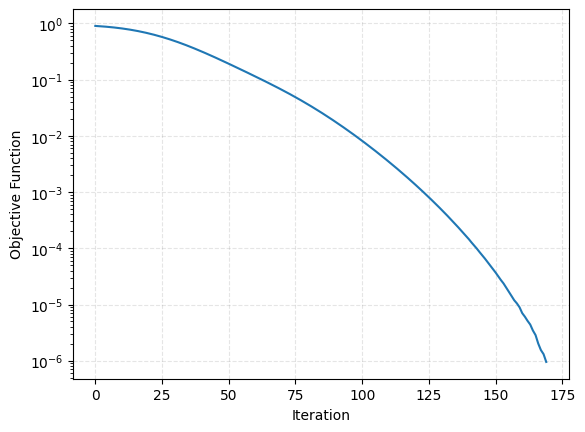

In [5]:
opt_result = optimizer.optimize()
opt_result.times

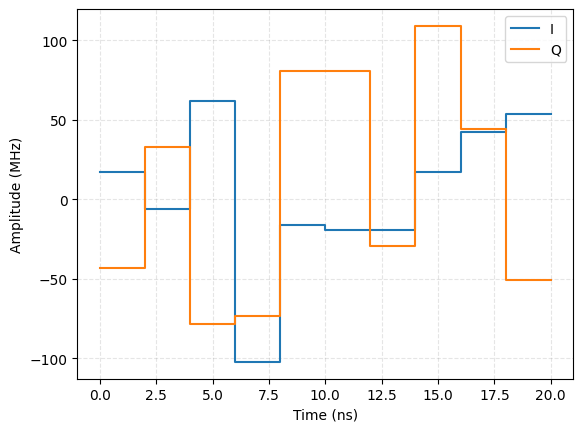

In [6]:
opt_result.plot_pulse()

In [7]:
sim_result = optimizer.simulate(
    pulse=opt_result.pulse,
    steps_per_segment=20,
)

In [8]:
sim_result.print_final_populations()

|0> : 33.38%
|1> : 33.32%
|2> : 33.29%


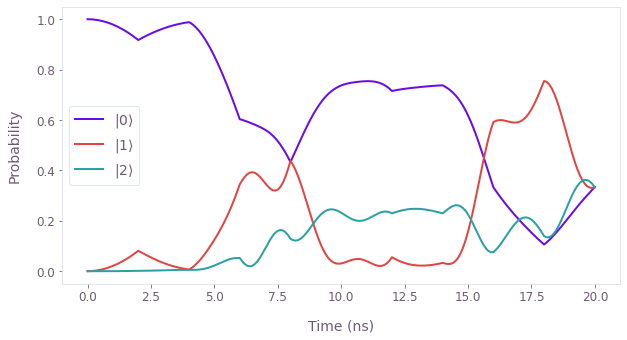

In [9]:
sim_result.plot_populations()

In [10]:
sim_result.display_bloch_sphere()

<IPython.core.display.Javascript object>

## Hadmard gate

In [11]:
target_unitary = qt.Qobj(
    [
        [1, 1],
        [1, -1],
    ]
) / np.sqrt(2)
target_unitary

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

In [12]:
optimizer = PulseOptimizer(
    dimension=2,
    detuning=0.0,
    anharmonicity=-0.3,
    segment_count=2,
    segment_width=25.0,
    max_rabi_rate=0.1,
    target_unitary=target_unitary.full(),
)

Converged in 198 iterations: 5.960464477539062e-07


OptimizationResult(times=Array([ 0., 25., 50.], dtype=float32), params=Array([ 0.6323627 , -0.10928813, -0.10282745, -0.29922697], dtype=float32), pulse=Array([ 0.6323627 -0.10928813j, -0.10282745-0.29922697j], dtype=complex64), history=[Array(0.80472624, dtype=float32), Array(0.76518905, dtype=float32), Array(0.7263068, dtype=float32), Array(0.6895377, dtype=float32), Array(0.6562381, dtype=float32), Array(0.6274489, dtype=float32), Array(0.60358775, dtype=float32), Array(0.5841813, dtype=float32), Array(0.56803286, dtype=float32), Array(0.5538496, dtype=float32), Array(0.5407039, dtype=float32), Array(0.52806735, dtype=float32), Array(0.5154347, dtype=float32), Array(0.50330544, dtype=float32), Array(0.4913633, dtype=float32), Array(0.47969896, dtype=float32), Array(0.46843702, dtype=float32), Array(0.45771205, dtype=float32), Array(0.44765347, dtype=float32), Array(0.43837386, dtype=float32), Array(0.4299599, dtype=float32), Array(0.42246318, dtype=float32), Array(0.41589445, dtype=

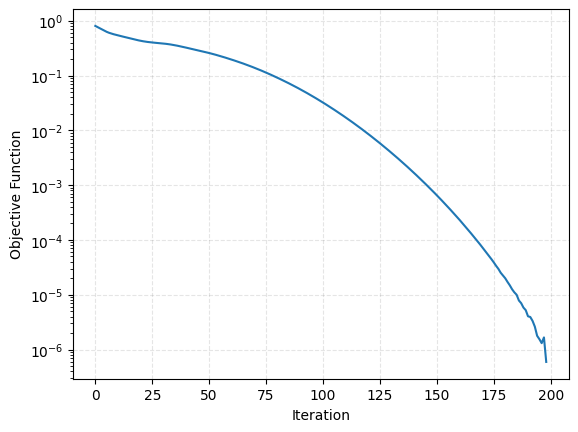

In [13]:
opt_result = optimizer.optimize()
opt_result

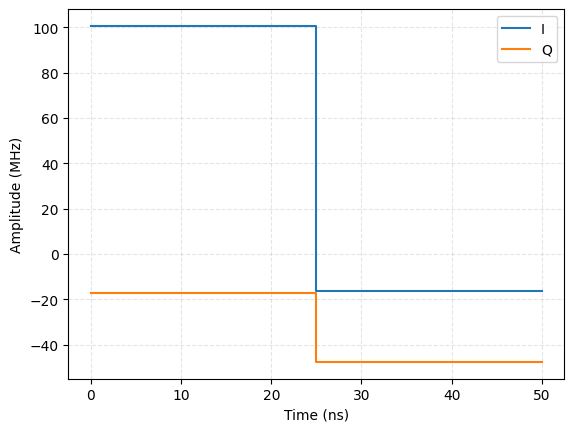

In [14]:
opt_result.plot_pulse()

In [15]:
sim_result = optimizer.simulate(
    pulse=opt_result.pulse,
    steps_per_segment=20,
)

In [16]:
sim_result.print_final_populations()

|0> : 50.03%
|1> : 49.97%


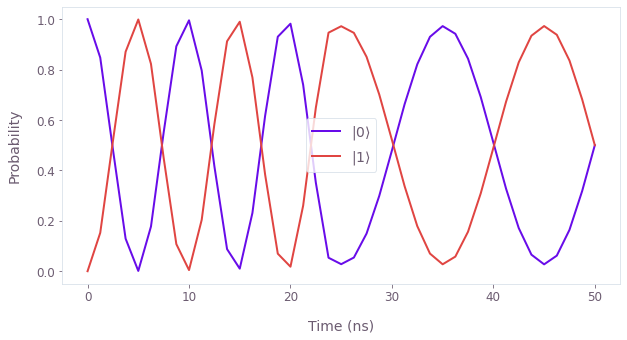

In [17]:
sim_result.plot_populations()

In [18]:
sim_result.display_bloch_sphere()

<IPython.core.display.Javascript object>